# PS3 - GMM
## Li Ruixue

### 1. Lognormal and GMM
#### (a) Plot histogram of percentages of incomes.txt with 30 bins.

In [211]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

integration_limit = 1000

%matplotlib inline
pts = np.loadtxt('incomes.txt')
pts[:10]

array([53711.54439888, 99731.23334901, 84773.60541676, 75184.025931  ,
       73390.9559334 , 77276.56474964, 82597.32702898, 76098.11372822,
       91850.97696668, 71750.0904012 ])

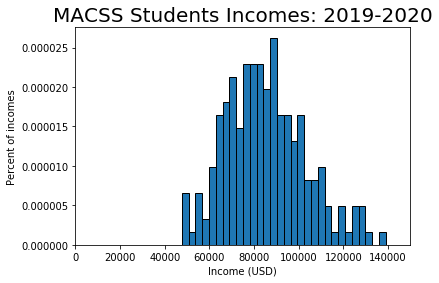

In [212]:
plt.hist(pts, 30, edgecolor='black', normed=True)
plt.title('MACSS Students Incomes: 2019-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()

#### (b) Estimate with identity matrix as W and plot estimated lognormal PDF, report value of GMM criterion function, report and compare data moments with estimated moments.

In [213]:
def lognorm_pdf(xvals, mu, sigma, cutoff):
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, loc=np.exp(mu), scale=sigma)
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, loc=np.exp(mu), scale=sigma) -
                       sts.lognorm.cdf(0, loc=np.exp(mu), scale=sigma))
            
    pdf_vals    = ((1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (xvals - mu)**2 / (2 * sigma**2))) /
                    prob_notcut)
    '''
    if cutoff == 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(0, s = sigma, scale=np.exp(mu))
    else:
        prob_notcut = (sts.lognorm.cdf(cutoff, s = sigma, scale=np.exp(mu)) -
                       sts.lognorm.cdf(0, s = sigma, scale=np.exp(mu)))
            
    pdf_vals    = sts.lognorm.pdf(xvals, s = sigma, scale=np.exp(mu))/(prob_notcut)
    return pdf_vals

def data_moments(xvals):
    mean_data = xvals.mean()
    sd_data = xvals.std()
    return mean_data, sd_data


def model_moments(mu, sigma, cutoff):
    xfx = lambda x: x * lognorm_pdf(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff, limit = integration_limit)
    x2fx = lambda x: ((x - mean_model) ** 2) * lognorm_pdf(x, mu, sigma, cutoff) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, cutoff, limit = integration_limit)
    sd_model = np.sqrt(var_model)

    return mean_model, sd_model


def err_vec(xvals, mu, sigma, cutoff, simple):

    mean_data, sd_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [sd_data]])
    mean_model, sd_model = model_moments(mu, sigma, cutoff)
    moms_model = np.array([[mean_model], [sd_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):

    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


In [214]:
mu_init = 11
sig_init = 0.2
cutoff = 150000
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (pts, cutoff, W_hat)
results1 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results1.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
print(results1)

mu_GMM1= 11.333599510006398  sig_GMM1= 0.21325521904176079
      fun: array([[1.88850193e-13]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.08012441e-07, -3.40902781e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 11
   status: 0
  success: True
        x: array([11.33359951,  0.21325522])


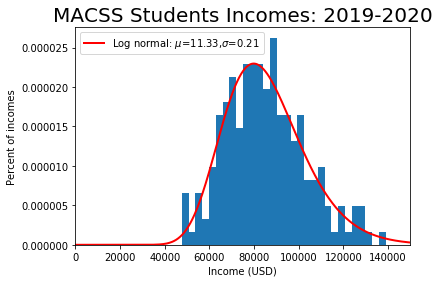

The value of criterion function:  1.8885019274771217e-13
The data moments:  (85276.82360625811, 17992.542128046523)
The model moments:  (85276.81484687593, 17992.53453060311)


In [215]:
plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff),
         linewidth=2, color='r', label='Log normal: $\mu$={:.2f},$\sigma$={:.2f}'.format(mu_GMM1, sig_GMM1))
plt.legend(loc='upper left')

plt.title('MACSS Students Incomes: 2019-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
print("The value of criterion function: ", float(results1.fun))
print('The data moments: ', data_moments(pts))
print('The model moments: ', model_moments(mu_GMM1, sig_GMM1, cutoff))

#### Perform two-step GMM, plot, report and compare

In [216]:
err1 = err_vec(pts, mu_GMM1, sig_GMM1, cutoff, False)
VCV2 = np.dot(err1, err1.T) / pts.shape[0]
print(VCV2)
W_hat2 = lin.pinv(VCV2) 
print(W_hat2)

[[5.27539429e-17 2.16863973e-16]
 [2.16863973e-16 8.91497021e-16]]
[[5.91670683e+13 2.43227422e+14]
 [2.43227422e+14 9.99873418e+14]]


In [217]:
np.seterr(all = 'ignore')
mu_init = 11
sig_init = 0.2
cutoff = 150000
params_init = np.array([mu_GMM1, sig_GMM1])
gmm_args = (pts, cutoff, W_hat2)
results2 = opt.minimize(criterion, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x
print('mu_GMM2=', mu_GMM2, ' sig_GMM2=', sig_GMM2)

/Users/liruixue/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


mu_GMM2= 11.33359953335889  sig_GMM2= 0.2132553170884952


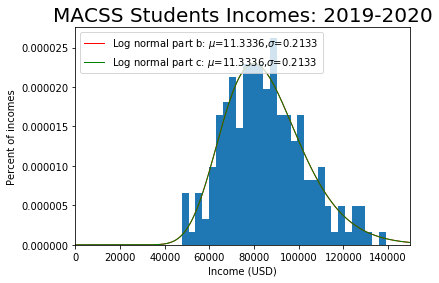

The value of criterion function:  0.06391679985314322
The data moments:  (85276.82360625811, 17992.542128046523)
The model moments:  (85276.81765785608, 17992.542289492456)


In [229]:
plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff),
         linewidth=1, color='r', label='Log normal part b: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM1, sig_GMM1))
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM1, sig_GMM1, cutoff),
         linewidth=1, color='g', label='Log normal part c: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM2, sig_GMM2))
plt.legend(loc='upper left')

plt.title('MACSS Students Incomes: 2019-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
print("The value of criterion function: ", float(results2.fun))
print('The data moments: ', data_moments(pts))
print('The model moments: ', model_moments(mu_GMM2, sig_GMM2, cutoff))

In [221]:
def data_moments2(xvals):

    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >=75000) & (xvals < 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals >=100000].shape[0] / xvals.shape[0]
    return bpct_1_dat, bpct_2_dat, bpct_3_dat


def model_moments2(mu, sigma, cutoff):

    xfx = lambda x: lognorm_pdf(x, mu, sigma, cutoff)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 0, 75000, limit = integration_limit)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = intgr.quad(xfx, 100000, cutoff)
    return bpct_1_mod, bpct_2_mod, bpct_3_mod


def err_vec2(xvals, mu, sigma, cutoff, simple):
    
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments2(xvals)
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments2(mu, sigma, cutoff)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

def criterion2(params, *args):

    mu, sigma = params
    xvals, cutoff, W = args
    err = err_vec2(xvals, mu, sigma, cutoff, simple=False)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val


In [222]:
mu_init = 11
sig_init = 0.2
cutoff = 150000
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(3)
gmm_args = (pts, cutoff, W_hat)
results3 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM3, sig_GMM3 = results3.x
print(results3)

mu_GMM1= 11.33670517988964  sig_GMM1= 0.21151351612141503
      fun: array([[2.4611484e-11]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.91291986e-05, 8.64433311e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 14
   status: 0
  success: True
        x: array([11.33670518,  0.21151352])


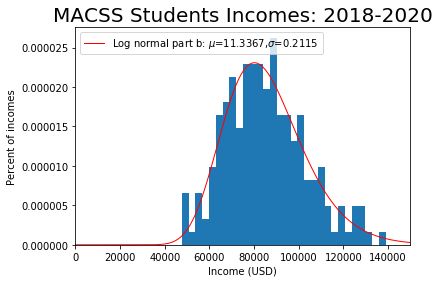

The value of criterion function:  2.461148404161175e-11
The data moments:  (0.3, 0.5, 0.2)
The model moments:  (0.30000000348066785, 0.5000000058755075, 0.19999999064382473)


In [224]:
plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff),
         linewidth=1, color='r', label='Log normal part b: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM3, sig_GMM3))
plt.legend(loc='upper left')

plt.title('MACSS Students Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
print("The value of criterion function: ", float(results3.fun))
print('The data moments: ', data_moments2(pts))
print('The model moments: ', model_moments2(mu_GMM3, sig_GMM3, cutoff))

#### (e) Perform two step GMM with 3 moments, plot, report, compare

[[ 6.73058266e-15  6.81689674e-15 -2.71381155e-14]
 [ 6.81689674e-15  6.90431774e-15 -2.74861391e-14]
 [-2.71381155e-14 -2.74861391e-14  1.09422520e-13]]
mu_GMM4= 11.336705181546044  sig_GMM4= 0.21151351822958908


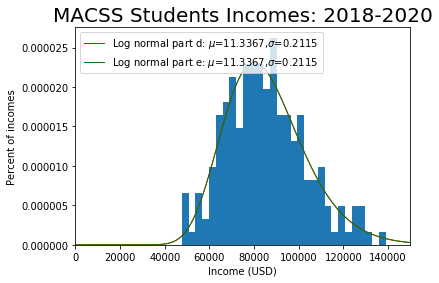

The value of criterion function:  59.341064242586064
The data moments:  (0.3, 0.5, 0.2)
The model moments:  (0.3000000026789677, 0.5000000023712502, 0.19999999494978232)


In [228]:
err2 = err_vec2(pts, mu_GMM3, sig_GMM3, cutoff, False)
VCV3 = np.dot(err2, err2.T) / pts.shape[0]
print(VCV3)
W_hat3 = lin.pinv(VCV3)
params_init = np.array([mu_GMM3, sig_GMM3])
gmm_args = (pts, cutoff, W_hat3)
results4 = opt.minimize(criterion2, params_init, args=(gmm_args),
                       method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results4.x
print('mu_GMM4=', mu_GMM4, ' sig_GMM4=', sig_GMM4)

plt.hist(pts, 30, normed=True)
dist_pts = np.linspace(1, 150000, 500)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM3, sig_GMM3, cutoff),
         linewidth=1, color='r', label='Log normal part d: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM3, sig_GMM3))
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM4, sig_GMM4, cutoff),
         linewidth=1, color='g', label='Log normal part e: $\mu$={:.4f},$\sigma$={:.4f}'.format(mu_GMM4, sig_GMM4))
plt.legend(loc='upper left')

plt.title('MACSS Students Incomes: 2018-2020', fontsize=20)
plt.xlabel('Income (USD)')
plt.ylabel('Percent of incomes')
plt.xlim([0, 150000]) 
plt.show()
print("The value of criterion function: ", float(results4.fun))
print('The data moments: ', data_moments2(pts))
print('The model moments: ', model_moments2(mu_GMM4, sig_GMM4, cutoff))

#### (e) Which estimation fits the data best? 
They are identical up to 2nd decimal place and they are pretty similar in my opinion. In principle, since the last model is over-identified and used 2-step GMM, it should be the most accurate.